# Movie Recommendation System Analysis

This notebook demonstrates how the movie recommendation system is trained and used. It shows:
1. Initial model training process
2. How the trained model is used in production

In [10]:
import pandas as pd
import tensorflow as tf
import numpy as np
import logging
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

GENRE_CHOICES = [
    'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
    'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
    'Thriller', 'War', 'Western'
]

## Helper Functions
First, let's define all our helper functions for data processing and recommendations.

### load_and_preprocess_data
This function loads two csvs and joins them together. It also creates new features for ratings, average rating and ratings count.

In [11]:
def load_and_preprocess_data(movies_path='movies.csv', ratings_path='ratings.csv'):
    """
    Load and preprocess the MovieLens dataset for our recommendation system.
    """
    logger.info("Loading data...")
    
    # Load raw data
    movies = pd.read_csv(movies_path)
    ratings = pd.read_csv(ratings_path)
    
    # Rename columns to match Django model
    movies = movies.rename(columns={'movieId': 'movie_id'})
    ratings = ratings.rename(columns={'movieId': 'movie_id'})
    
    # Convert IDs to strings for consistency
    movies['movie_id'] = movies['movie_id'].astype(str)
    ratings['movie_id'] = ratings['movie_id'].astype(str)
    
    # Split genres and create binary columns
    movies['genres'] = movies['genres'].str.split('|')
    for genre in GENRE_CHOICES:
        movies[genre] = movies['genres'].apply(lambda x: 1.0 if genre in x else 0.0)
    
    # Calculate rating statistics
    rating_stats = ratings.groupby('movie_id').agg({
        'rating': ['mean', 'count']
    }).reset_index()
    rating_stats.columns = ['movie_id', 'mean', 'count']
    
    # Merge ratings with movies
    movies = movies.merge(rating_stats, on='movie_id', how='left')
    
    # Handle missing values
    movies['mean'] = movies['mean'].fillna(0)
    movies['count'] = movies['count'].fillna(0)
    
    return movies

### MovieGenreModel

This class is the actual machine learning model definition. It is using the tensorflow keras model.

The model uses seven layers to predict ratings using genre information.

In [12]:
@tf.keras.utils.register_keras_serializable()
class MovieGenreModel(tf.keras.Model):
    def __init__(self, movies=None, vocabulary=None, **kwargs):
        super().__init__(**kwargs)
        # Handle vocabulary from either movies DataFrame or direct input
        if movies is not None:
            self.vocabulary = movies['movie_id'].unique().astype(str)
        else:
            self.vocabulary = vocabulary

        # Initialize layers in build method instead
        self.movie_embedding = None
        self.genre_embedding = None
        self.rating_predictor = None
        
    def build(self, input_shape):
        # Initialize layers here
        self.movie_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=self.vocabulary,
                mask_token=None),
            tf.keras.layers.Embedding(
                input_dim=len(self.vocabulary) + 1 if self.vocabulary is not None else 1000,
                output_dim=32)
        ])
        
        self.genre_embedding = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32)
        ])
        
        self.rating_predictor = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        
        self.built = True

    def call(self, inputs):
        movie_emb = self.movie_embedding(inputs['movieId'])
        genre_emb = self.genre_embedding(inputs['genre_preferences'])
        combined = tf.concat([movie_emb, genre_emb], axis=1)
        return self.rating_predictor(combined)

    def get_config(self):
        config = super().get_config()
        config.update({
            "vocabulary": self.vocabulary.tolist() if self.vocabulary is not None else None
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Convert vocabulary back to numpy array if it exists
        vocabulary = config.pop('vocabulary')
        if vocabulary is not None:
            vocabulary = np.array(vocabulary)
        return cls(vocabulary=vocabulary, **config)

In [13]:
def create_training_dataset(movies_data, batch_size=128):
    return tf.data.Dataset.from_tensor_slices((
        {
            'movieId': movies_data['movie_id'].values,
            'genre_preferences': movies_data[GENRE_CHOICES].values.astype(np.float32)
        },
        movies_data['mean'].values
    )).batch(batch_size)

def train_model(movies_data, epochs=10, batch_size=128):
    model = MovieGenreModel(movies=movies_data)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.MeanSquaredError()
    )
    
    dataset = create_training_dataset(movies_data, batch_size)
    history = model.fit(dataset, epochs=epochs)
    
    return model, history

### prepare_genre_preferences

This function converts the user input into an input that the model can use.

In [ ]:
def prepare_genre_preferences(preference):
    genre_preferences = np.zeros(len(GENRE_CHOICES))
    
    selected_genres = [
        preference.genre1,
        preference.genre2,
        preference.genre3,
        preference.genre4,
        preference.genre5
    ]
    selected_genres = [g for g in selected_genres if g and g.strip()]
    
    for genre in selected_genres:
        try:
            index = GENRE_CHOICES.index(genre)
            genre_preferences[index] = 1
        except ValueError:
            continue
    
    if not preference.include_other_genres:
        genre_preferences = np.where(genre_preferences == 0, -1, genre_preferences)
    
    return genre_preferences.astype(np.float32)



### get_recommendations

This is the powerhouse of the recommendation engine as a whole.
Currently the model is only one component of the recommendation process, but the goal is to keep upgrading it until it can do the whole process on its own.

Right now the model output is weighted to be 40% of the actual recommendation generated.

Output weights:
- model             : 40%
- average ratings   : 30%
- preference_score  : 30%

The model output is weighted against the preferences of the user and actual ratings of the movies.

In the future the model should be 100% responsible for this process.

In [ ]:
def get_recommendations(model, movies_data, genre_preferences, top_k=10, min_ratings=50):
    popular_movies = movies_data[movies_data['count'] >= min_ratings].copy()
    if len(popular_movies) == 0:
        popular_movies = movies_data[movies_data['count'] > 0].copy()
    
    features = {
        'movieId': tf.constant(popular_movies['movie_id'].values),
        'genre_preferences': tf.repeat(
            tf.convert_to_tensor([genre_preferences], dtype=tf.float32),
            repeats=[len(popular_movies)],
            axis=0
        )
    }
    
    predicted_scores = model(features)
    
    preference_scores = np.zeros(len(popular_movies))
    for idx, pref in enumerate(genre_preferences):
        genre_name = GENRE_CHOICES[idx]
        if pref == 1:
            preference_scores += popular_movies[genre_name].values * 0.5
        elif pref == -1:
            preference_scores -= popular_movies[genre_name].values * 1.0
    
    predicted_scores = tf.cast(predicted_scores, tf.float32)
    avg_ratings = tf.cast(popular_movies['mean'].values, tf.float32)
    preference_scores = tf.cast(preference_scores, tf.float32)
    
    predicted_scores = (predicted_scores - tf.reduce_min(predicted_scores)) / (
        tf.reduce_max(predicted_scores) - tf.reduce_min(predicted_scores) + 1e-8)
    avg_ratings_normalized = (avg_ratings - tf.reduce_min(avg_ratings)) / (
        tf.reduce_max(avg_ratings) - tf.reduce_min(avg_ratings) + 1e-8)
    
    final_scores = (
        0.4 * tf.squeeze(predicted_scores) +
        0.3 * avg_ratings_normalized +
        0.3 * preference_scores
    )
    
    avoid_mask = np.ones(len(popular_movies), dtype=bool)
    for idx, pref in enumerate(genre_preferences):
        if pref == -1:
            genre_name = GENRE_CHOICES[idx]
            avoid_mask = avoid_mask & (popular_movies[genre_name] == 0)
    
    final_scores = tf.where(
        tf.constant(avoid_mask),
        final_scores,
        tf.fill(final_scores.shape, tf.float32.min)
    )
    
    k = min(top_k, tf.reduce_sum(tf.cast(avoid_mask, tf.int32)))
    if k == 0:
        return None
    
    _, indices = tf.math.top_k(final_scores, k=k)
    recommendations = popular_movies.iloc[indices.numpy()]
    
    recommendations = recommendations.copy()
    recommendations['model_score'] = predicted_scores.numpy()[indices.numpy()]
    recommendations['preference_score'] = preference_scores.numpy()[indices.numpy()]
    recommendations['final_score'] = final_scores.numpy()[indices.numpy()]
    
    return recommendations

## Training the Model
Now that we have all our functions defined, let's load the data and train the model.

INFO:root:Loading data...


Epoch 1/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2.0716
Epoch 2/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3984
Epoch 3/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2426
Epoch 4/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1857
Epoch 5/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1985
Epoch 6/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1815
Epoch 7/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1123
Epoch 8/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0815
Epoch 9/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1073
Epoch 10/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1710


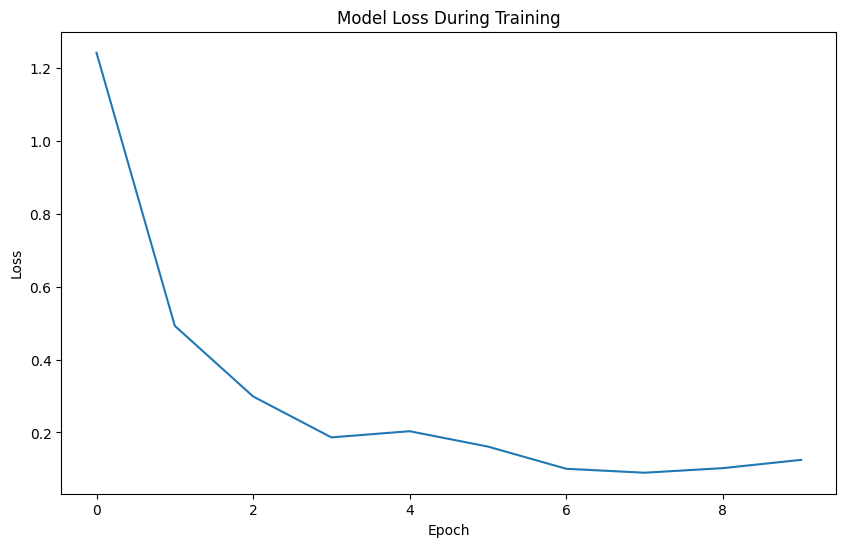

In [15]:
movies_data = load_and_preprocess_data()
model, history = train_model(movies_data)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

model.save('genreModel.keras')

# Clear model from memory
del model
tf.keras.backend.clear_session()

## Testing the Saved Model
Now let's load the saved model and test it with some example preferences.

In [16]:
custom_objects = {'MovieGenreModel': MovieGenreModel}
model = tf.keras.models.load_model('genreModel.keras', custom_objects=custom_objects)

class ExamplePreference:
    def __init__(self):
        self.genre1 = 'Action'
        self.genre2 = 'Adventure'
        self.genre3 = None
        self.genre4 = None
        self.genre5 = None
        self.include_other_genres = True

# Test with Action/Adventure preferences
pref = ExamplePreference()
genre_preferences = prepare_genre_preferences(pref)
recommendations = get_recommendations(model, movies_data, genre_preferences)
recommendations[['title', 'genres', 'mean', 'count', 'final_score']]

c:\MLNotebook\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


,title,genres,mean,count,final_score
5905,City of God (Cidade de Deus) (2002),"[Action, Adventure, Crime, Drama, Thriller]",4.178663,25688.0,0.910016
1171,"Good, the Bad and the Ugly, The (Buono, il bru...","[Action, Adventure, Western]",4.134063,22922.0,0.903587
26646,The Pacific (2010),"[Action, Adventure, Drama, War]",4.002980,839.0,0.896708
7658,Captain Blood (1935),"[Action, Adventure, Romance]",3.808036,560.0,0.887014
1184,Army of Darkness (1993),"[Action, Adventure, Comedy, Fantasy, Horror]",3.731796,14379.0,0.878349
85445,Dungeons & Dragons: Honor Among Thieves (2023),"[Action, Adventure, Fantasy]",3.690541,740.0,0.859093
1221,"Treasure of the Sierra Madre, The (1948)","[Action, Adventure, Drama, Western]",4.114552,6377.0,0.854143
7185,"Black Pirate, The (1926)","[Action, Adventure]",3.508929,56.0,0.852086
6966,Hero (Ying xiong) (2002),"[Action, Adventure, Drama]",3.895628,9744.0,0.845804
9639,"Three Musketeers, The (1973)","[Action, Adventure, Comedy]",3.604250,753.0,0.842134


## Testing with Different Preferences
Let's try a different combination of genres.

In [17]:
pref.genre1 = 'Comedy'
pref.genre2 = 'Romance'
pref.include_other_genres = False

genre_preferences = prepare_genre_preferences(pref)
recommendations = get_recommendations(model, movies_data, genre_preferences)
recommendations[['title', 'genres', 'mean', 'count', 'final_score']].head()

,title,genres,mean,count,final_score
7553,Smiles of a Summer Night (Sommarnattens leende...,"[Comedy, Romance]",3.929325,474.0,0.905884
13628,Gigantic (2008),"[Comedy, Romance]",3.119048,147.0,0.888767
29642,Walking the Streets of Moscow (1963),"[Comedy, Romance]",3.592593,54.0,0.883257
2843,"Lady Eve, The (1941)","[Comedy, Romance]",4.068832,1678.0,0.865748
3427,Arthur (1981),"[Comedy, Romance]",3.304905,3160.0,0.859866
